# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

## Load all dependencies

In [7]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import shutil
import sys
import time

from azure.ai.agents import AgentsClient 
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose, ListSortOrder
from dotenv import load_dotenv
from IPython.display import display
from openai import AzureOpenAI
from PIL import Image

In [2]:
load_dotenv("azure.env")

True

## Connect to AI Foundry Project 

In [3]:
endpoint = os.getenv("PROJECT_ENDPOINT")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

## Get example file

In [4]:
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

output_file = os.path.join(DATA_DIR, "titanic.csv")

In [5]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-06-10 09:16:42--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.001s  

2025-06-10 09:16:42 (63.2 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [8]:
IMAGES_DIR = "images"

if os.path.exists(IMAGES_DIR):
    shutil.rmtree(IMAGES_DIR)
    print(f"Directory '{IMAGES_DIR}' has been deleted.")
else:
    print(f"Directory '{IMAGES_DIR}' does not exist.")

print(f"Creating directory: {IMAGES_DIR}")
os.makedirs(IMAGES_DIR, exist_ok=True)

Directory 'images' has been deleted.
Creating directory: images


In [9]:
model = "gpt-4o-mini"

In [10]:
HOME_DIR = os.getcwd()

## Upload file to agent

In [11]:
file = project_client.files.upload_and_poll(file_path=output_file, purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-FyG19MHS4boxPKbj12rwTq


## Create and agent with code interpreter tool

In [12]:
code_interpreter = CodeInterpreterTool(file_ids=[file.id])

# Create agent with code interpreter tool and tools_resources
agent = project_client.create_agent(
    model="gpt-4o",
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
    description="AI agent with code interpreter",
)

print(f"Created agent, agent ID: {agent.id} File ID: {file.id}")

Created agent, agent ID: asst_inXPJEQNA3AQnYkaHgxwXizT File ID: assistant-FyG19MHS4boxPKbj12rwTq


In [13]:
id1 = agent.id

## Create a thread for the agent to run

In [14]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Plot a correlation matrix using the blues theme"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_IM88EZ3LUMo2ht0zHpHVujV8
Created message, message ID: msg_Fv5kYHgTFhImHJVP7jazftgL
Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbc99082aa0>


## Run the code interpreter agent

In [15]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_JOgA32iDhp9txUVHK6CcKPAC


## Get the messaages genrated by the run

In [16]:
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

# Fetch and log all messages
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)

# Print last messages from the thread
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbcad91feb0>
user: Plot a correlation matrix using the blues theme
assistant: Let me first examine the uploaded file to understand its structure and contents. Then, I will generate a correlation matrix using the blues theme.
assistant: The dataset contains 891 entries and 12 columns, including both numerical and categorical data. To construct a correlation matrix, I'll use only the numerical columns.

Let's proceed with creating the correlation matrix and plotting it using a blue color theme.
assistant: Here is the correlation matrix plotted using the "Blues" theme. Each value represents the correlation between two numerical columns from the dataset, ranging from -1 (strong negative correlation) to 1 (strong positive correlation). Let me know if you'd like any further analysis or adjustments!


## Save image(s) generated by the run

In [17]:
images_list = []

os.chdir(IMAGES_DIR)

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
    for img in msg.image_contents:
        file_id = img.image_file.file_id
        file_name = f"{file_id}_image_file.png"
        project_client.files.save(file_id=file_id, file_name=file_name)
        print(f"Saved image file to: {file_name}")

    # Print details of every file-path annotation
    for ann in msg.file_path_annotations:
        print("File Paths:")
        print(f"  Type: {ann.type}")
        print(f"  Text: {ann.text}")
        print(f"  File ID: {ann.file_path.file_id}")
        print(f"  Start Index: {ann.start_index}")
        print(f"  End Index: {ann.end_index}")
        
    # Print last messages from the thread
    for msg in messages:
        if msg.text_messages:
            last_text = msg.text_messages[-1]
            print(f"{msg.role}: {last_text.text.value}")
            
os.chdir(HOME_DIR)

Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbcad8f6fb0>
Saved image file to: assistant-AWYdZZ4U57nebnFK2q1EyC_image_file.png
assistant: The dataset contains 891 entries and 12 columns, including both numerical and categorical data. To construct a correlation matrix, I'll use only the numerical columns.

Let's proceed with creating the correlation matrix and plotting it using a blue color theme.
assistant: Let me first examine the uploaded file to understand its structure and contents. Then, I will generate a correlation matrix using the blues theme.
user: Plot a correlation matrix using the blues theme


### Display image

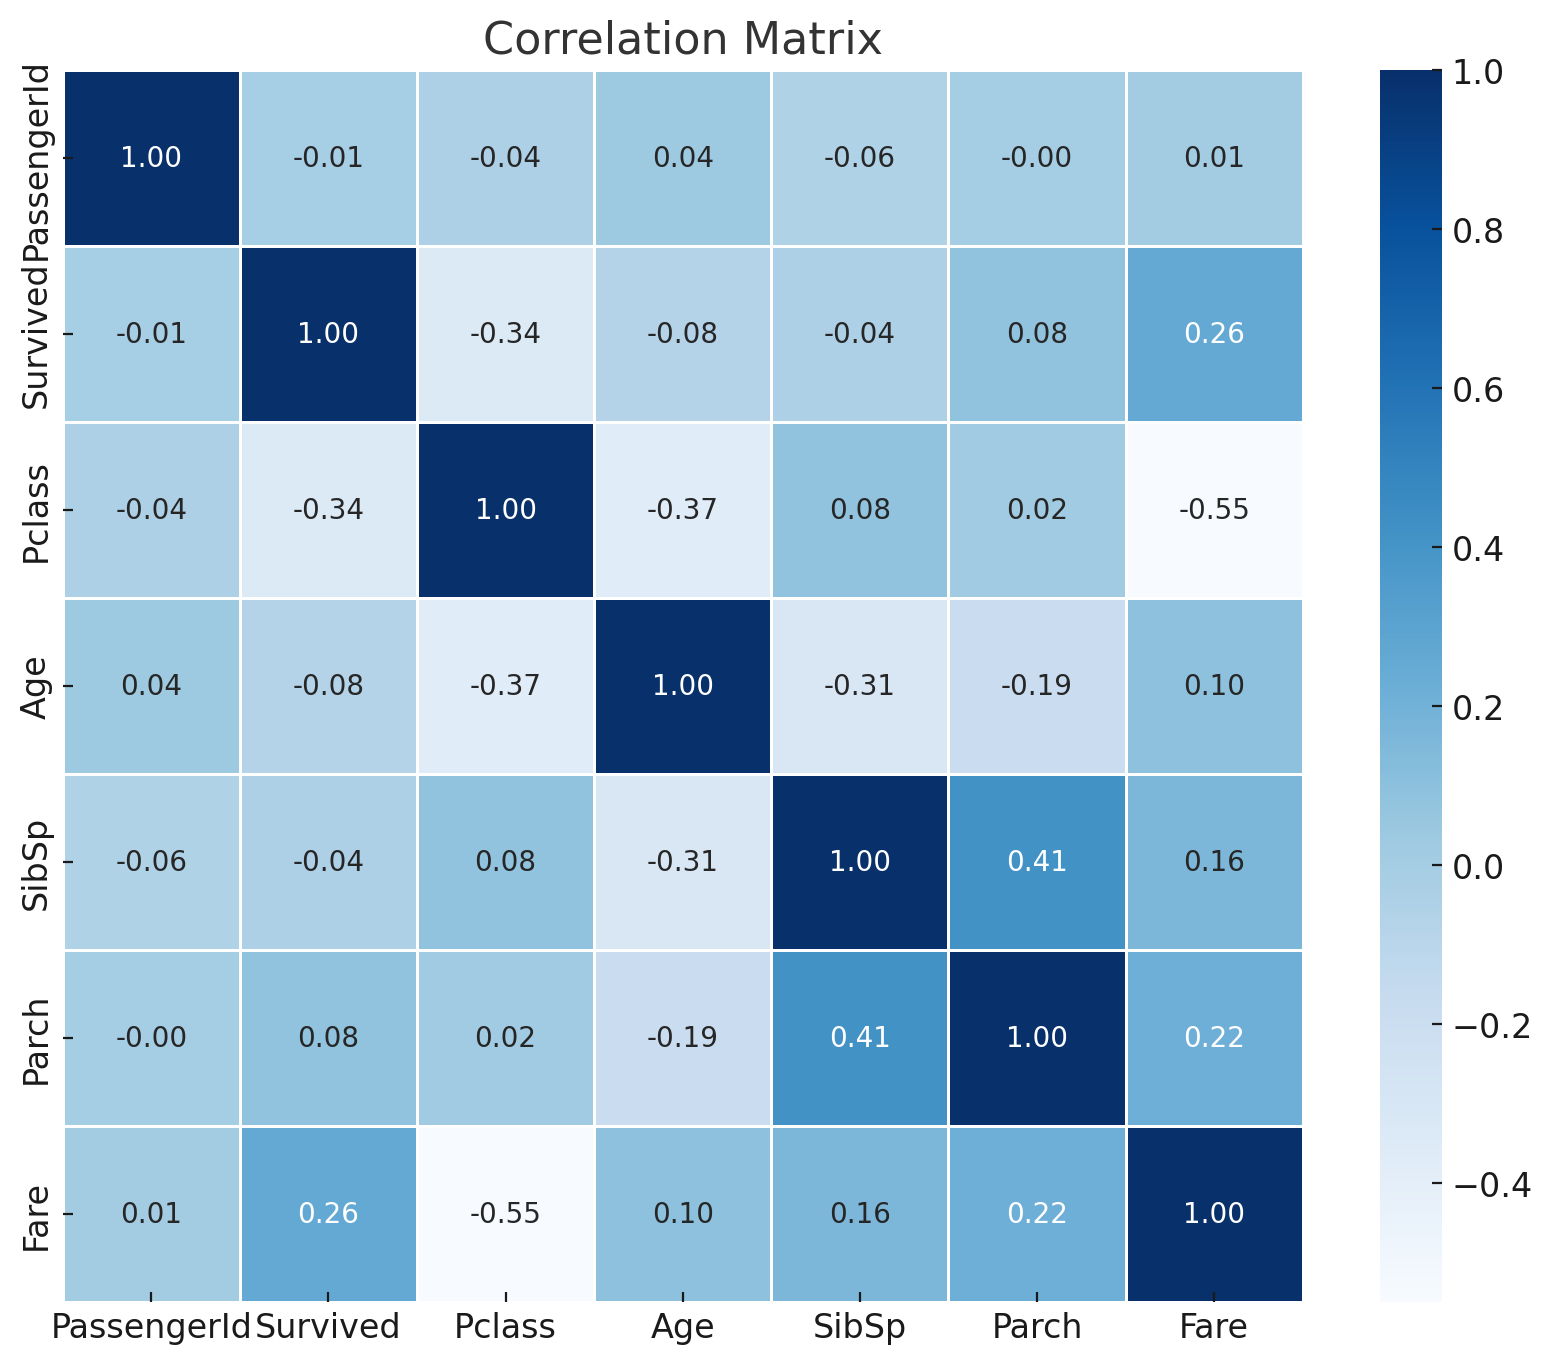

In [18]:
img = Image.open(os.path.join(IMAGES_DIR, file_name))
img

## Example

In [19]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a survival count by Gender plot and the age distribution. Use some blues colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_3xwgdSGw9B6BiqVGsP0Ii5Gy
Created message, message ID: msg_3YPsLqOPRMOGJvjLzLpYleo1


In [20]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_bnhgulTYMIdzZIxjXckEXuyb


In [21]:
run.usage

{'prompt_tokens': 5752, 'completion_tokens': 477, 'total_tokens': 6229, 'prompt_token_details': {'cached_tokens': 0}}

In [22]:
images_list = []

os.chdir(IMAGES_DIR)

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
    for img in msg.image_contents:
        file_id = img.image_file.file_id
        file_name = f"{file_id}_image_file.png"
        project_client.files.save(file_id=file_id, file_name=file_name)
        print(f"Saved image file to: {file_name}")

    # Print details of every file-path annotation
    for ann in msg.file_path_annotations:
        print("File Paths:")
        print(f"  Type: {ann.type}")
        print(f"  Text: {ann.text}")
        print(f"  File ID: {ann.file_path.file_id}")
        print(f"  Start Index: {ann.start_index}")
        print(f"  End Index: {ann.end_index}")
        
    # Print last messages from the thread
    for msg in messages:
        if msg.text_messages:
            last_text = msg.text_messages[-1]
            print(f"{msg.role}: {last_text.text.value}")
            
os.chdir(HOME_DIR)

Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbcad90aa70>
Saved image file to: assistant-HVwj5scGQoknaWhB1zeZoN_image_file.png
Saved image file to: assistant-2hVHxYe6r8DV5WS62mL3q3_image_file.png
assistant: The dataset appears to be from the Titanic dataset, containing passenger details. We can analyze the data columns relevant for the plots:

1. To generate the survival count by gender plot, we will use the `Survived` and `Sex` columns.
2. To analyze the age distribution, we'll use the `Age` column.

Let’s create the requested plots with blue color tones.
assistant: Let me first inspect the contents of the uploaded file to ensure that I analyze the data accordingly.
user: Generate a survival count by Gender plot and the age distribution. Use some blues colors.


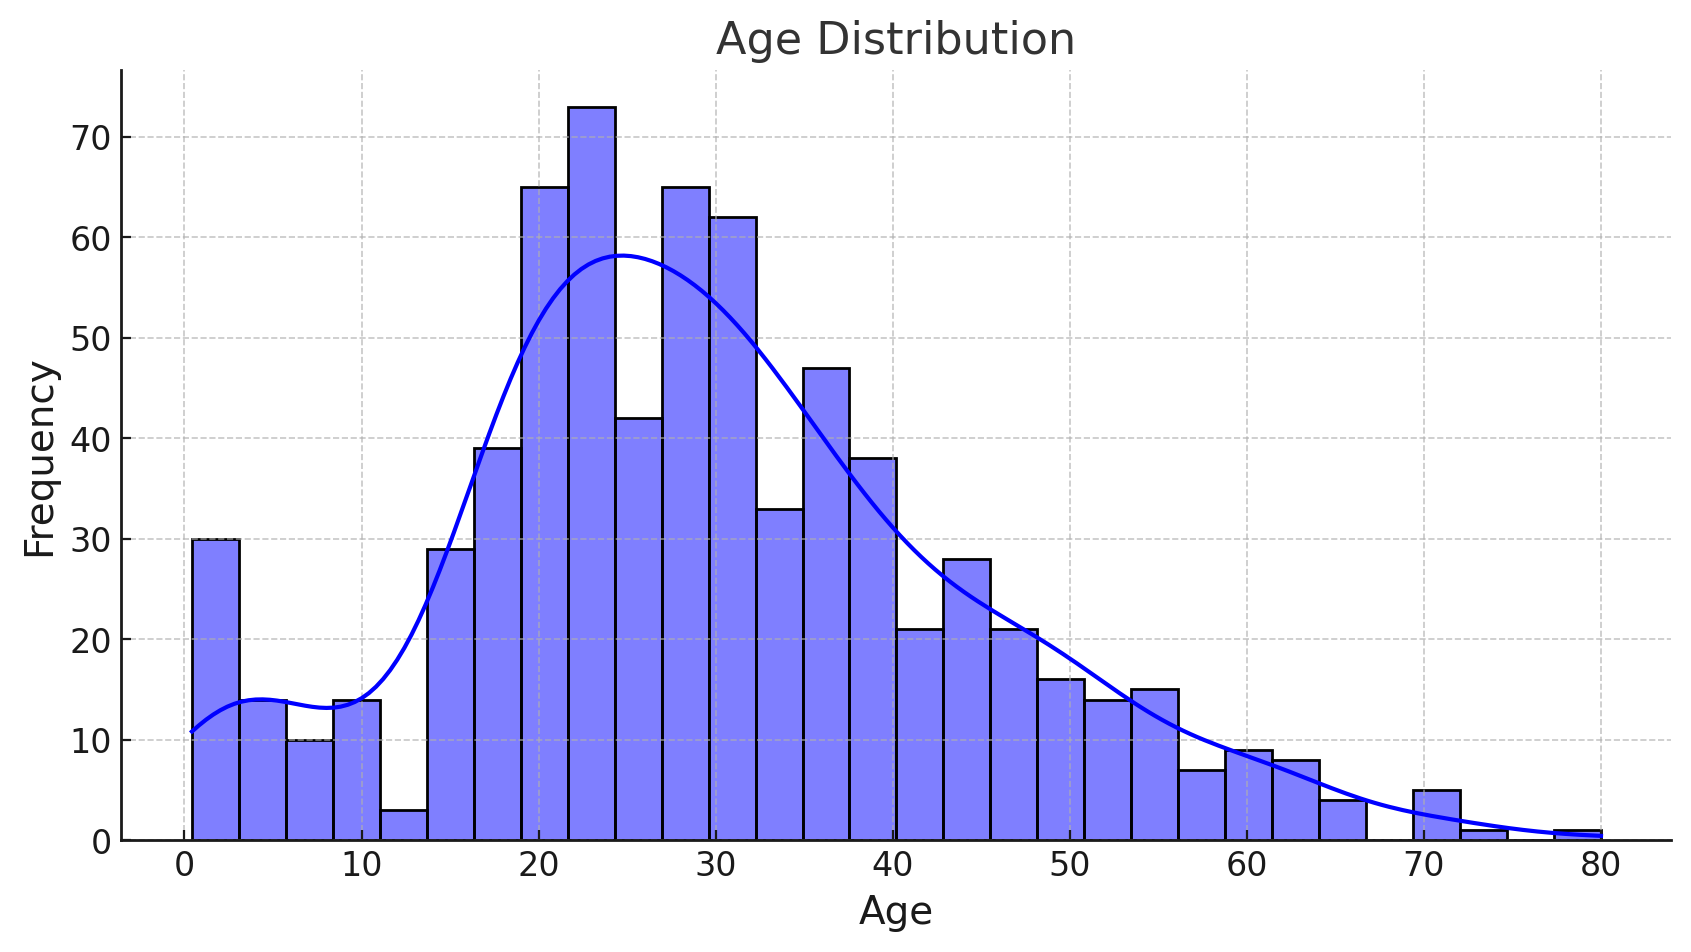

In [23]:
img = Image.open(os.path.join(IMAGES_DIR, file_name))
img

## Example

In [24]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_XraTzi3LMeLgDmh7RhP48SKa
Created message, message ID: msg_FNoYkZ6CpGv7YLClW5wsDTav


In [25]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_xR7fdndOaEdNVrh1eHyJIbTa


In [26]:
run.usage

{'prompt_tokens': 4092, 'completion_tokens': 455, 'total_tokens': 4547, 'prompt_token_details': {'cached_tokens': 0}}

In [27]:
images_list = []

os.chdir(IMAGES_DIR)

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
    for img in msg.image_contents:
        file_id = img.image_file.file_id
        file_name = f"{file_id}_image_file.png"
        project_client.files.save(file_id=file_id, file_name=file_name)
        print(f"Saved image file to: {file_name}")

    # Print details of every file-path annotation
    for ann in msg.file_path_annotations:
        print("File Paths:")
        print(f"  Type: {ann.type}")
        print(f"  Text: {ann.text}")
        print(f"  File ID: {ann.file_path.file_id}")
        print(f"  Start Index: {ann.start_index}")
        print(f"  End Index: {ann.end_index}")
        
    # Print last messages from the thread
    for msg in messages:
        if msg.text_messages:
            last_text = msg.text_messages[-1]
            print(f"{msg.role}: {last_text.text.value}")
            
os.chdir(HOME_DIR)

Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbc99083b20>
Saved image file to: assistant-9ihDTzL2V59hu2djAJxmDr_image_file.png
assistant: The dataset contains columns including "Survived" (indicating survival status), and "Pclass" (indicating passenger class). We will now proceed to create a bivariate analysis of these two variables using a green color scheme.
assistant: Let's analyze the data in the uploaded file by generating a bivariate analysis of "Survival" and "Pclass" with a green-colored scheme. I'll first inspect the structure of the dataset to locate these variables.
user: Generate a bivariate analysis of survival and pclass. Use some greens colors.


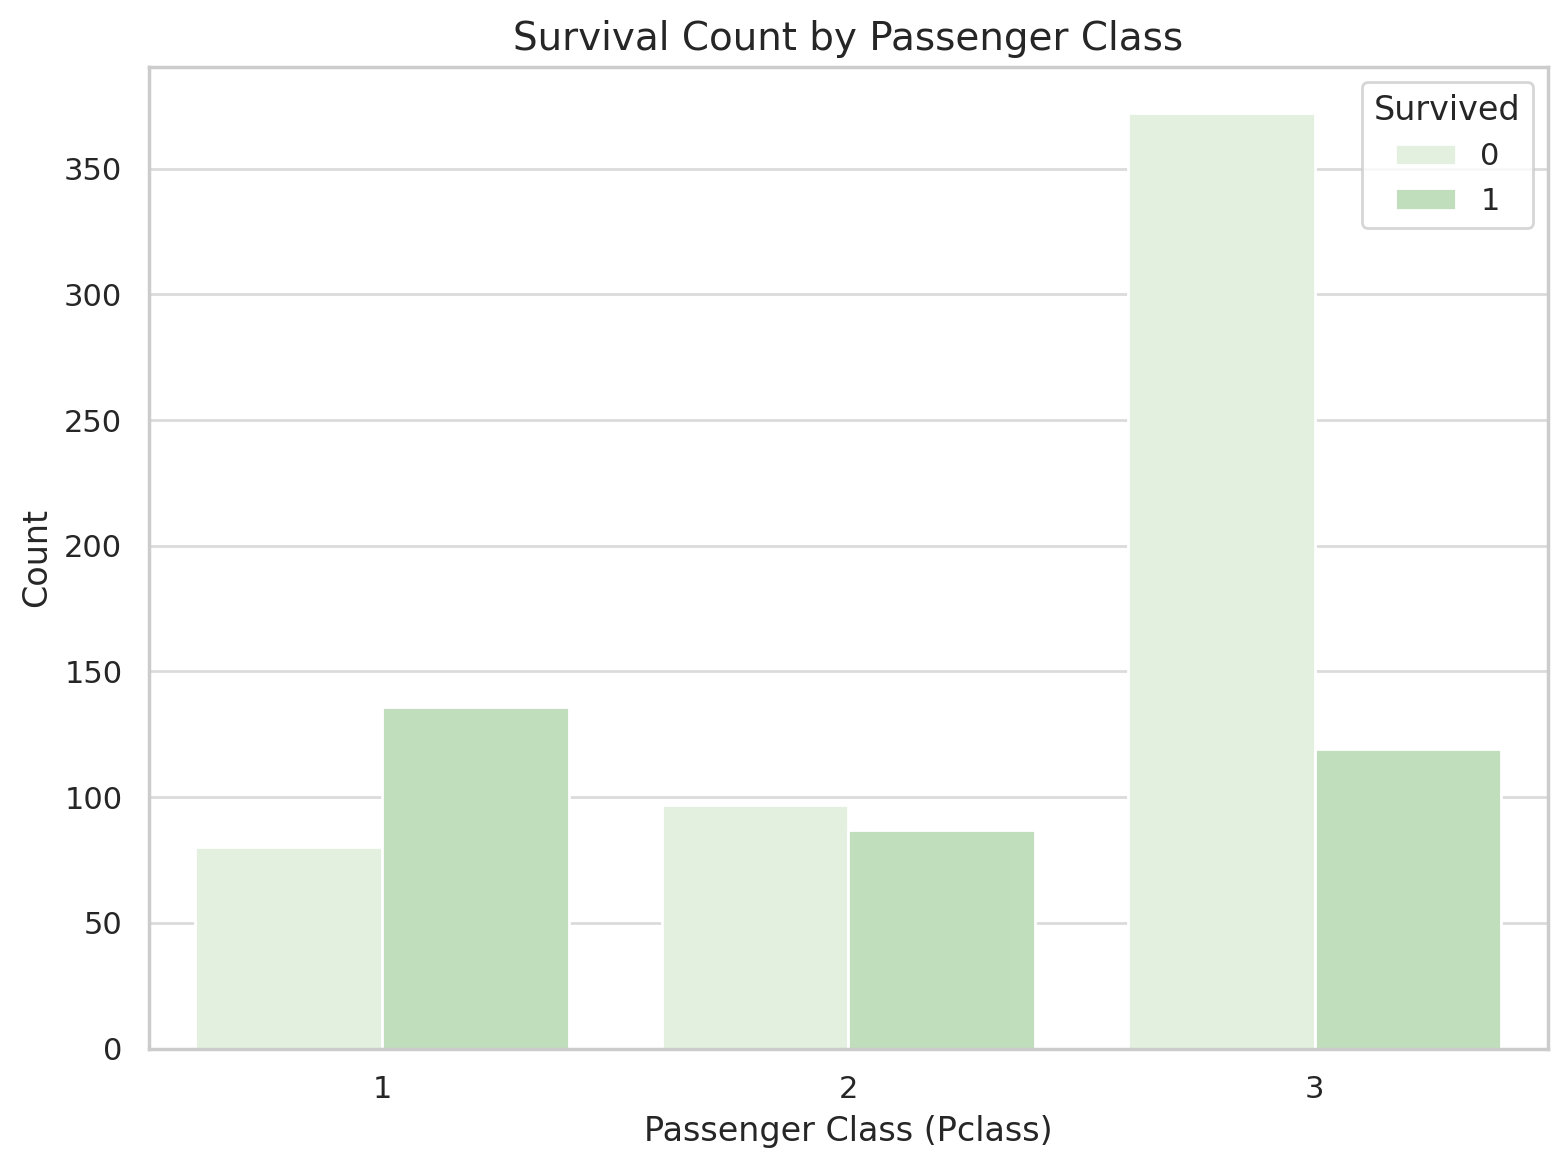

In [28]:
img = Image.open(os.path.join(IMAGES_DIR, file_name))
img

## Example

In [29]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_Ku90sFPN831Vfgxvvyfw1S0j
Created message, message ID: msg_gfbxxNm02cz83qa7dbxBV1TW


In [30]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_ygEmJPymUfRwz0VE4EQ1BtOx


{'prompt_tokens': 4822, 'completion_tokens': 410, 'total_tokens': 5232, 'prompt_token_details': {'cached_tokens': 0}}

In [31]:
images_list = []

os.chdir(IMAGES_DIR)

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
    for img in msg.image_contents:
        file_id = img.image_file.file_id
        file_name = f"{file_id}_image_file.png"
        project_client.files.save(file_id=file_id, file_name=file_name)
        print(f"Saved image file to: {file_name}")

    # Print details of every file-path annotation
    for ann in msg.file_path_annotations:
        print("File Paths:")
        print(f"  Type: {ann.type}")
        print(f"  Text: {ann.text}")
        print(f"  File ID: {ann.file_path.file_id}")
        print(f"  Start Index: {ann.start_index}")
        print(f"  End Index: {ann.end_index}")
        
    # Print last messages from the thread
    for msg in messages:
        if msg.text_messages:
            last_text = msg.text_messages[-1]
            print(f"{msg.role}: {last_text.text.value}")
            
os.chdir(HOME_DIR)

Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbcadaf0a00>
Saved image file to: assistant-HsWxRV4rbJSLhc2cjdyoYy_image_file.png
assistant: The dataset contains 12 columns, with relevant columns being:

- `Pclass`: Passenger class (1, 2, or 3).
- `Age`: Age of the passengers, but it has missing values (714 non-null entries out of 891).
- `Sex`: Gender of the passengers (`male` or `female`).

We will create a violin plot of `Pclass` by `Age` grouped by `Gender`. Missing values in the `Age` column will be removed for this purpose. I will now generate the requested plot using lime and cyan colors.
assistant: To generate the requested violin plot of `Pclass` by `Age` and `Gender`, I will first explore the uploaded file to check its contents and understand its structure. Let me do that.
user: Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.


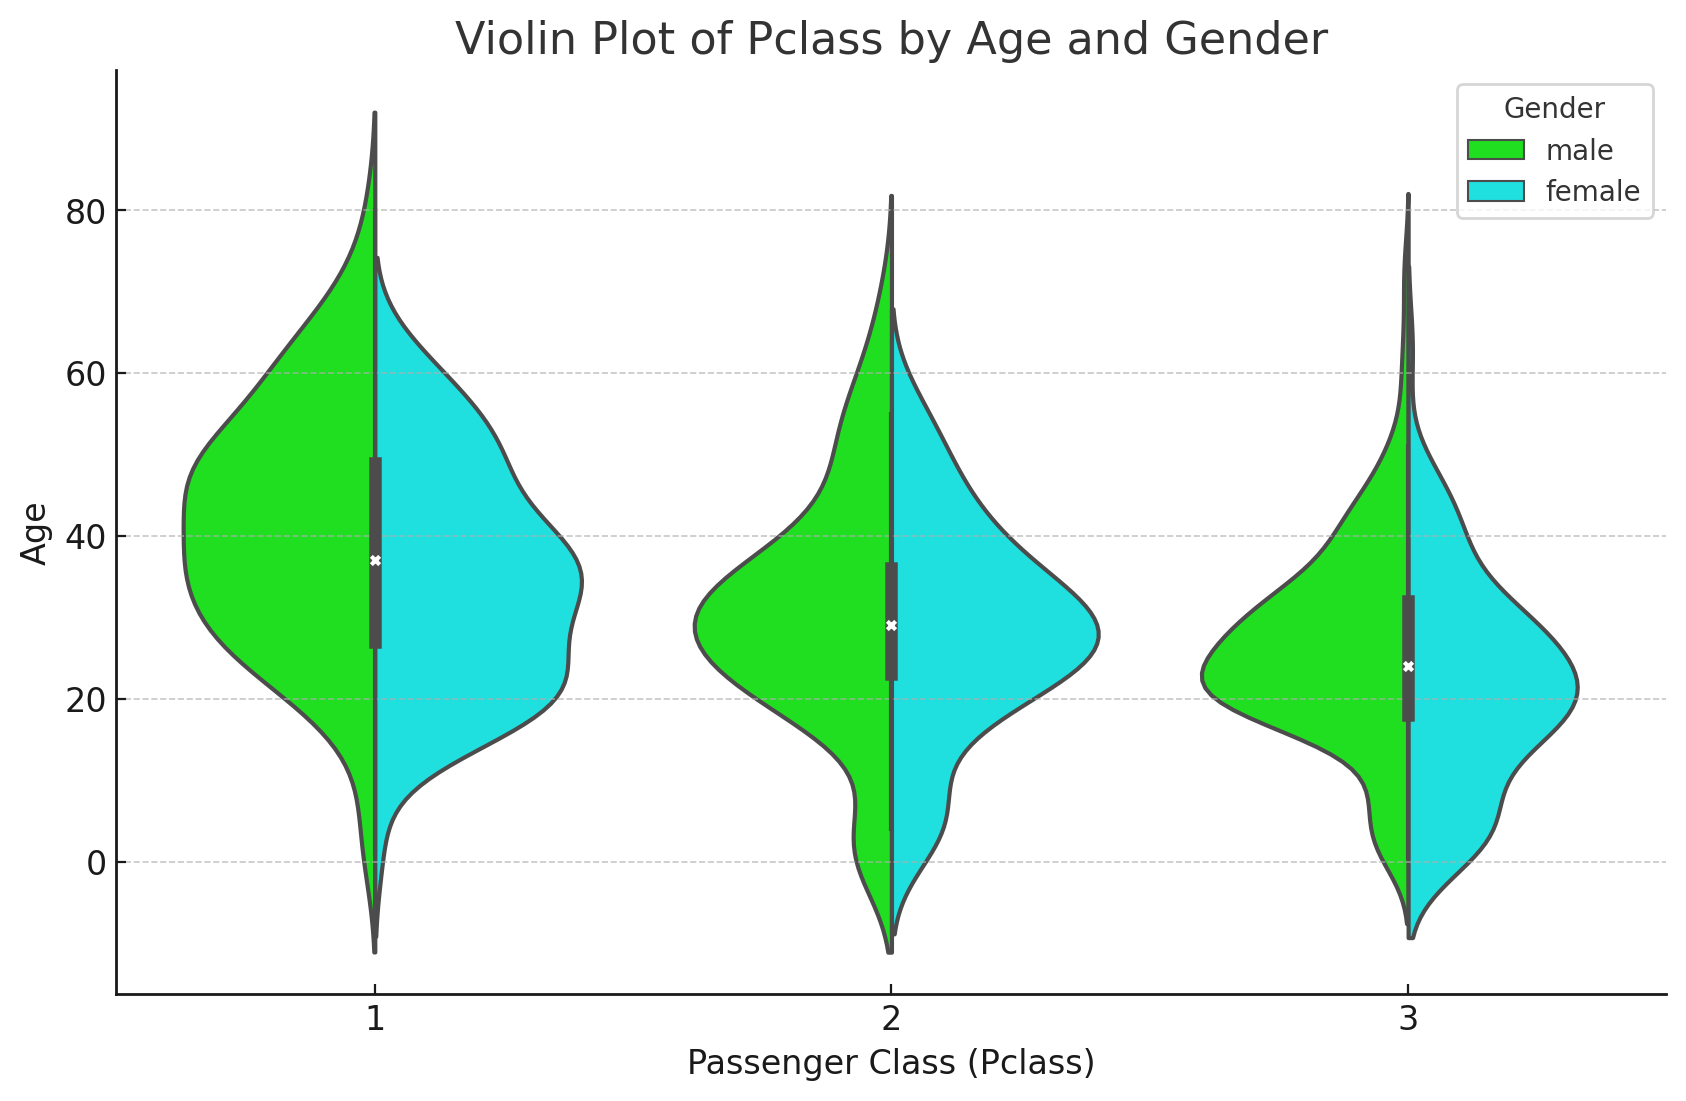

In [32]:
img = Image.open(os.path.join(IMAGES_DIR, file_name))
img

## Example

In [33]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate the age distribution. Use lightblue color"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_dtyOhl4pb2UdcFx4AKSDVcCt
Created message, message ID: msg_vvCX82c9EWERbQhqZnNrh6DK


In [34]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_t2JLKhh5xeXGdt3btbdCZNZ1


{'prompt_tokens': 5502, 'completion_tokens': 430, 'total_tokens': 5932, 'prompt_token_details': {'cached_tokens': 0}}

In [35]:
images_list = []

os.chdir(IMAGES_DIR)

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
    for img in msg.image_contents:
        file_id = img.image_file.file_id
        file_name = f"{file_id}_image_file.png"
        project_client.files.save(file_id=file_id, file_name=file_name)
        print(f"Saved image file to: {file_name}")

    # Print details of every file-path annotation
    for ann in msg.file_path_annotations:
        print("File Paths:")
        print(f"  Type: {ann.type}")
        print(f"  Text: {ann.text}")
        print(f"  File ID: {ann.file_path.file_id}")
        print(f"  Start Index: {ann.start_index}")
        print(f"  End Index: {ann.end_index}")
        
    # Print last messages from the thread
    for msg in messages:
        if msg.text_messages:
            last_text = msg.text_messages[-1]
            print(f"{msg.role}: {last_text.text.value}")
            
os.chdir(HOME_DIR)

Messages: <iterator object azure.core.paging.ItemPaged at 0x7fbcad90ca00>
Saved image file to: assistant-MkK6t7jGXXwnyXyJmrXK1k_image_file.png
assistant: The "Age" column contains 177 missing values. For the analysis, I will exclude these missing values to proceed with plotting the age distribution histogram using a light blue color. Let's visualize this now.
assistant: The dataset is from a Titanic passenger list, and the relevant column for the age distribution is the "Age" column. I will now create a histogram of the "Age" column using light blue color. First, I will check for missing data in the "Age" column to ensure proper handling.
assistant: Let's start by examining the structure of the uploaded file so I can understand its contents and locate the necessary columns to generate the age distribution. This might include loading the data and inspecting the headers or metadata. Let me proceed.
user: Generate the age distribution. Use lightblue color


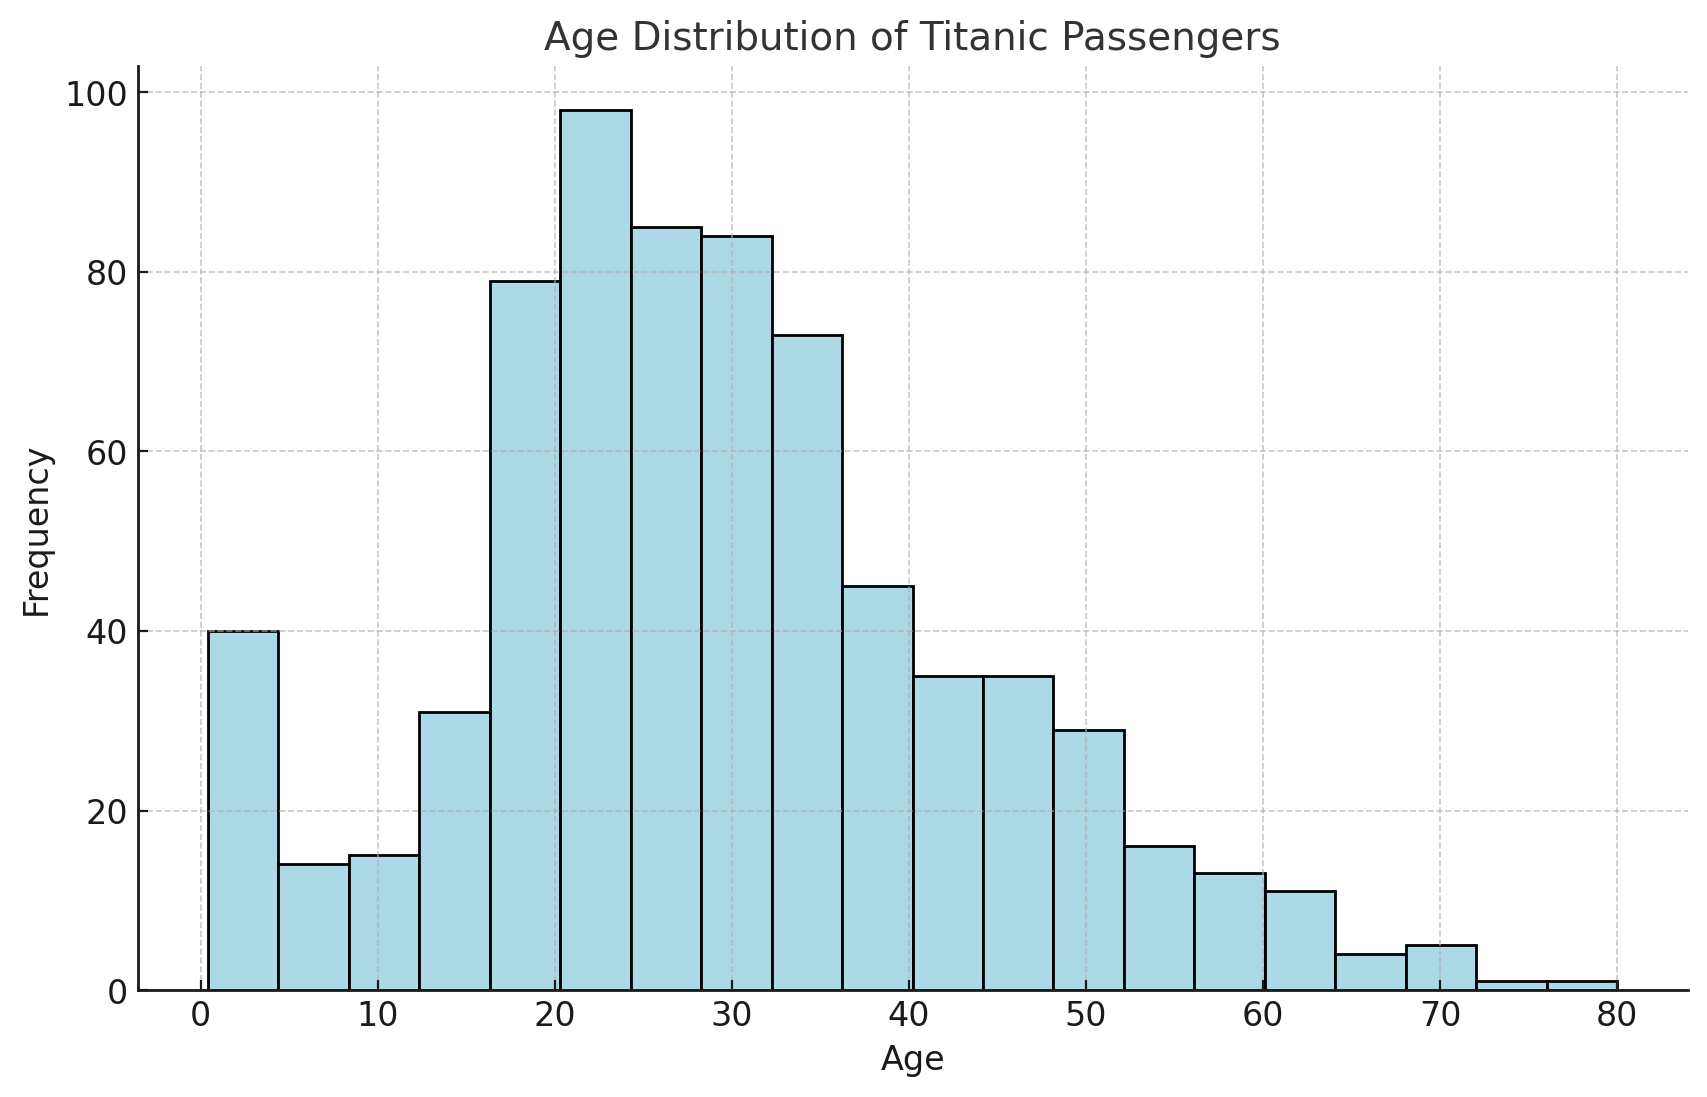

In [36]:
img = Image.open(os.path.join(IMAGES_DIR, file_name))
img

In [37]:
!ls $IMAGES_DIR/*.* -lh

-rwxrwxrwx 1 root root  86K Jun 10 09:17 images/assistant-2hVHxYe6r8DV5WS62mL3q3_image_file.png
-rwxrwxrwx 1 root root  58K Jun 10 09:18 images/assistant-9ihDTzL2V59hu2djAJxmDr_image_file.png
-rwxrwxrwx 1 root root 150K Jun 10 09:17 images/assistant-AWYdZZ4U57nebnFK2q1EyC_image_file.png
-rwxrwxrwx 1 root root  54K Jun 10 09:17 images/assistant-HVwj5scGQoknaWhB1zeZoN_image_file.png
-rwxrwxrwx 1 root root 131K Jun 10 09:18 images/assistant-HsWxRV4rbJSLhc2cjdyoYy_image_file.png
-rwxrwxrwx 1 root root  66K Jun 10 09:18 images/assistant-MkK6t7jGXXwnyXyJmrXK1k_image_file.png


## Cleaning

In [38]:
# List all agents in the project
print("Listing all agents in the project:")

agents = project_client.list_agents()
for agent in agents:
    print(f"Agent ID: {agent.id}, Name: {agent.name}, Model: {agent.model}, Instructions: {agent.instructions}")

Listing all agents in the project:
Agent ID: asst_inXPJEQNA3AQnYkaHgxwXizT, Name: my-agent, Model: gpt-4o, Instructions: You are helpful agent


In [39]:
project_client.delete_agent(id1)
print(f"Deleted agent, agent ID: {id1}")

Deleted agent, agent ID: asst_inXPJEQNA3AQnYkaHgxwXizT
